In [1]:
import numpy as np
import networkx as nx



# Question 1

In [2]:
!curl -L 'http://snap.stanford.edu/data/ca-GrQc.txt.gz' -o "graph_dataset.gz"
!gunzip -f "graph_dataset.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  106k  100  106k    0     0  37476      0  0:00:02  0:00:02 --:--:-- 37469


In [3]:
class ErdosRenyi:

    def __init__(self, number_of_nodes, number_of_edges):
        '''
        m => number of nodes
        n => number of edges
        '''
        self.m = number_of_nodes
        self.n = number_of_edges
        self.create_graph()


    def create_graph(self):
        all_candidates = np.array([(i, j) for i in range(self.m) for j in range(i+1, self.m)])

        chosen_indices = np.random.choice(len(all_candidates), self.n, replace=False)

        self.graph = nx.from_edgelist(all_candidates[chosen_indices])

    def plot_graph(self):
        nx.draw(self.graph)

class SmallWorldRandomGraph:

    def __init__(self, nodes, shortcuts):
        self.m = nodes
        self.extra_shortcuts = shortcuts
        self.create_graph()

    def create_graph(self):
        self.graph = nx.empty_graph(self.m)

        # Create a circular lattice (a-b-c-a)
        for i in range(self.m):
            self.graph.add_edge(i,(i+1) % self.m)

        # Introduce short circuited edges
        for i in range(self.m):
            self.graph.add_edge(i, (i+2)%self.m)
            

        # Introduce random edges among the unconnected nodes
        max_allowed_shortcuts = self.m * (self.m-1)//2 - self.graph.number_of_edges()

        if self.extra_shortcuts > max_allowed_shortcuts: # 2 * m because of the addition of m edges in the first two steps
            raise ValueError(f"Shortcuts cannot be more then maximum number of shortcuts {max_allowed_shortcuts}")
        
        added = 0
        while added < self.extra_shortcuts:
            u, v = np.random.randint(0, self.m), np.random.randint(0, self.m)
            if u == v or self.graph.has_edge(u, v):
                continue
            self.graph.add_edge(u,v)
            added += 1


        
er_graph = ErdosRenyi(5242, 14484)
small_word_graph = SmallWorldRandomGraph(5242, 4000)
rw_collaboration_graph = nx.read_edgelist("graph_dataset")

# Remove the self edge in rw graph
for node in rw_collaboration_graph.nodes:
    if node in rw_collaboration_graph.adj[node]:
        rw_collaboration_graph.remove_edge(node, node)


## 1.1

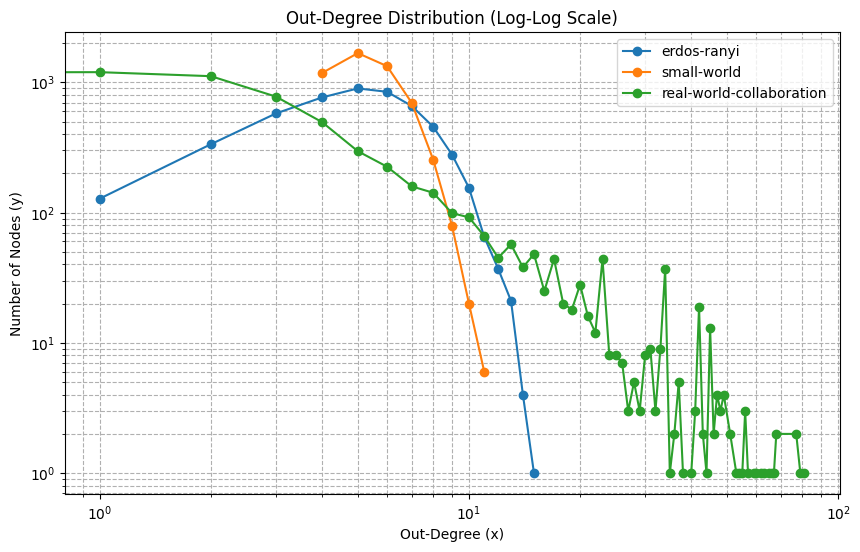

In [4]:
import matplotlib.pyplot as plt
import collections

plt.figure(figsize=(10, 6))
def plot_degree_distribution(G, label):
    degrees = [degree for node, degree in G.degree()]
    degree_counts = collections.Counter(degrees)

    # Sort the degree_counts by degree
    sorted_degree_counts = sorted(degree_counts.items())

    # Extract degrees and their counts
    degrees, counts = zip(*sorted_degree_counts)

    # Plot on a log-log scale
    plt.loglog(degrees, counts, marker='o', linestyle='-', label=label)

plot_degree_distribution(er_graph.graph, 'erdos-ranyi')
plot_degree_distribution(small_word_graph.graph, 'small-world')
plot_degree_distribution(rw_collaboration_graph, 'real-world-collaboration')

plt.title('Out-Degree Distribution (Log-Log Scale)')
plt.xlabel('Out-Degree (x)')
plt.ylabel('Number of Nodes (y)')
plt.legend()
plt.grid(True, which="both", ls="--")

In [5]:
def calculate_average_clustering_coefficient(G):

    average_clustering_coefficient = 0

    for node in G.nodes:
        neighbours = G.adj[node]
        neighbour_edges = set()

        if G.degree(node) < 2:
            continue

        neighbour_edges = set()
        for neighbour in neighbours:
            for neighbour_of_neighbour in G.adj[neighbour]:
                if neighbour_of_neighbour in neighbours and neighbour != node and neighbour_of_neighbour != neighbour:
                    a, b = neighbour, neighbour_of_neighbour
                    if a > b:
                        b,a = a,b
                    neighbour_edges.add((a,b))
        e = len(neighbour_edges)
        average_clustering_coefficient += 2 * e / (G.degree(node) * (G.degree(node) - 1))



    return average_clustering_coefficient / len(G.nodes) 

print(calculate_average_clustering_coefficient(er_graph.graph))
print(calculate_average_clustering_coefficient(small_word_graph.graph))
print(calculate_average_clustering_coefficient(rw_collaboration_graph))

0.0010639557146734171
0.28531009666072243
0.529635811052136


# Question 2 :  Structural Roles: Rolx and ReFex

In [6]:
!curl -L "http://www-personal.umich.edu/~mejn/netdata/netscience.zip" -o "netscience.zip"
!unzip -o "netscience.zip" -d netscience

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   246  100   246    0     0    289      0 --:--:-- --:--:-- --:--:--   289
100 28408  100 28408    0     0   6733      0  0:00:04  0:00:04 --:--:-- 11015
Archive:  netscience.zip
  inflating: netscience/netscience.gml  
  inflating: netscience/netscience.txt  


In [113]:
ns_graph = nx.read_gml("netscience/netscience.gml", label='id')
ns_graph = nx.Graph(ns_graph.to_undirected())
for _, _, d in ns_graph.edges(data=True):
    d.clear()

## 2.1 Basic Features

We begin by loading the graph G provided in the bundle and computing three basic features for
the nodes. For each node v, we choose 3 basic local features (in this order):
1. the degree of v, i.e., deg(v);
2. the number of edges in the egonet of v, where egonet of v is defined as the subgraph of G
induced by v and its neighborhood;
3. the number of edges that connect the egonet of v and the rest of the graph, i.e., the number
of edges that enter or leave the egonet of v.

In [114]:
from heapq import heappush, heappop

def get_basic_feature_vector(G, node):
    feature_vector = []

    # 1 degree f the node
    feature_vector.append(G.degree(node))

    # 2 number of edges in the egonet (node and it's immediate neighbours, and the edges that connect themselves)

    egonet = set(G.adj[node]) | {node}
    egonet_within_edges = 0
    seen_edges = set()
    for u in egonet:
        for v in G.adj[u]:
            if v in egonet and u != v:
                e = frozenset((u, v)) # Frozen set ensures (u, v) == (v, u)
                if e not in seen_edges:
                    seen_edges.add(e)
                    egonet_within_edges += 1
    feature_vector.append(egonet_within_edges)

    # 3 the number of edges that connect the egonet of v and the rest of the graph, i.e., the number of edges that enter or leave the egonet of v.

    egonet_outside_edges = 0
    for u in egonet:
        for v in G.adj[u]:
            if v not in egonet:
                egonet_outside_edges += 1
    feature_vector.append(egonet_outside_edges)

    return feature_vector

def norm_vector(vec_a):
    total_squared_sum = 0
    for component in vec_a:
        total_squared_sum += component ** 2
    return np.sqrt(total_squared_sum)

def dot_product(vec_a, vec_b):
    total_prod_sum = 0
    for comp_a, comp_b in zip(vec_a, vec_b):
        total_prod_sum += comp_a * comp_b
    return total_prod_sum

def get_similarity_score(vec_a, vec_b):
    norm_a = norm_vector(vec_a)
    norm_b = norm_vector(vec_b)

    if not norm_a or not norm_b:
        return 0

    return (dot_product(vec_a=vec_a, vec_b=vec_b)/(norm_a * norm_b)).item()

feature_vectors = {}
for node in ns_graph:
    feature_vectors[node] = get_basic_feature_vector(ns_graph, node)

#Compute the basic feature vector for the node with ID 9, and report the top 5 nodes that are most similar to 9
similarity_scores = []
feature_vector_source = feature_vectors[9]

for node in ns_graph:
    if node != 9:
        feature_vector_node = feature_vectors[node]
        similarity_scores.append([get_similarity_score(feature_vector_source, feature_vector_node), node])
    
similarity_scores.sort()

print(f"The feature vector of node 9 is {feature_vectors[9]}")
print(f"The top 5 nodes most similar to 9 are {[node for score, node in similarity_scores[-5:]]}")
print(similarity_scores[-5:])


The feature vector of node 9 is [6, 10, 1]
The top 5 nodes most similar to 9 are [1054, 1336, 286, 288, 415]
[[0.9961182380000687, 1054], [0.9961182380000687, 1336], [0.996343680627828, 286], [0.996343680627828, 288], [0.9996157540684272, 415]]


## 2.2 Recursive Features [8 points]



In [115]:
def add_two_vector(vec_a, vec_b):
    sum_vector = []
    for comp_a, comp_b in zip(vec_a, vec_b):
        sum_vector.append(comp_a + comp_b)
    return sum_vector

def cal_mean_vector(G, node, feature_vector_map):
    neighbours = list(G.adj[node])
    mean_vector = [0] * len(feature_vector_map[node])

    if not neighbours:
        return mean_vector
    
    for u in neighbours:
        u_vec = feature_vector_map[u]
        mean_vector = add_two_vector(mean_vector, u_vec)
    
    N = len(neighbours)
    for idx in range(len(mean_vector)):
        mean_vector[idx] /= N

    return mean_vector

def cal_sum_vector(G, node, feature_vector_map):

    neighbours = list(G.adj[node])
    sum_vector = [0] * len(feature_vector_map[node])

    if not neighbours:
        return sum_vector
    
    for u in neighbours:
        u_vec = feature_vector_map[u]
        sum_vector = add_two_vector(sum_vector, u_vec)

    return sum_vector

k = 2
for iteration in range(k):
    temp_feature_vectors = feature_vectors.copy()
    for node in ns_graph.nodes:
        temp_feature_vectors[node] = feature_vectors[node] + cal_mean_vector(ns_graph, node, feature_vectors) + cal_sum_vector(ns_graph, node, feature_vectors)
    feature_vectors = temp_feature_vectors.copy()

# Compute the basic feature vector for the node with ID 9, and report the top 5 nodes that are most similar to 9

similarity_scores = []
feature_vector_source = feature_vectors[9]

for node in ns_graph:
    if node != 9:
        feature_vector_node = feature_vectors[node]
        similarity_scores.append([get_similarity_score(feature_vector_source, feature_vector_node), node])
    
similarity_scores.sort()

print(f"The feature vector of node 9 is {feature_vectors[9]}")
print(f"The top 5 similarity scores are {[score for score, node in similarity_scores[-5:]]}")
print(f"The top 5 nodes most similar to 9 are {[node for score, node in similarity_scores[-5:]]}") 

The feature vector of node 9 is [6, 10, 1, 2.5, 4.333333333333333, 4.0, 15, 26, 24, 2.5, 4.333333333333333, 4.0, 4.319444444444444, 7.347222222222222, 2.388888888888889, 10.166666666666666, 17.5, 6.5, 15, 26, 24, 25.916666666666664, 44.083333333333336, 14.333333333333332, 61, 105, 39]
The top 5 similarity scores are [0.9922413199302673, 0.9922839741918226, 0.993728442523926, 0.9946130044020558, 0.9959848829010806]
The top 5 nodes most similar to 9 are [25, 496, 415, 537, 973]


## 2.3 Role Discovery 

### 2.3 a

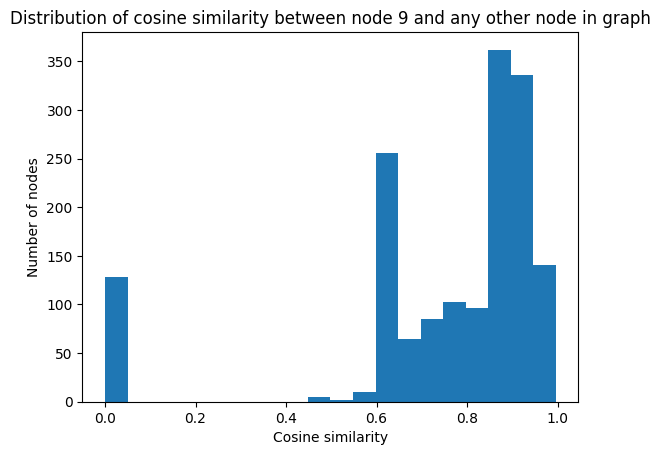

In [116]:
import matplotlib.pyplot as plt

'''
Question a : (a) Produce a 20-bin histogram to show the distribution of cosine similarity between node 9 and
any other node in the graph (according to their recursive feature vectors). Note here that the x-axis
is cosine similarity with node 9, and the y-axis is the number of nodes. [3 points]
'''

plt.hist([score for score, node in similarity_scores], bins=20)
plt.xlabel('Cosine similarity')
plt.ylabel('Number of nodes')
plt.title('Distribution of cosine similarity between node 9 and any other node in graph')
plt.show()

### 2.3 b

In [127]:
peaks = [0, 0.4, 0.85, 0.9]

threshold = 0.1

sampled_nodes = []

i = 0
for peak in peaks:
    for score, node in similarity_scores:

        if peak - threshold <= score <= peak + threshold:
            sampled_nodes.append(node)
            break

# Create sub graph
sub_graph = nx.empty_graph()
# sub_graph.add_node(9)

def bfs(queue, G1, G2, limit=2):
    k = 0
    while queue:
        
        if k > limit:
            break
        for _ in range(len(queue)):
            curr_node, curr_parent = queue.pop(0)
            G2.add_edge(curr_parent, curr_node)
            for adj_node in G1.adj[curr_node]:
                if adj_node == curr_parent:
                    continue
                queue.append((adj_node, curr_node))

        k += 1
sampled_nodes

[19, 641, 1536, 162]

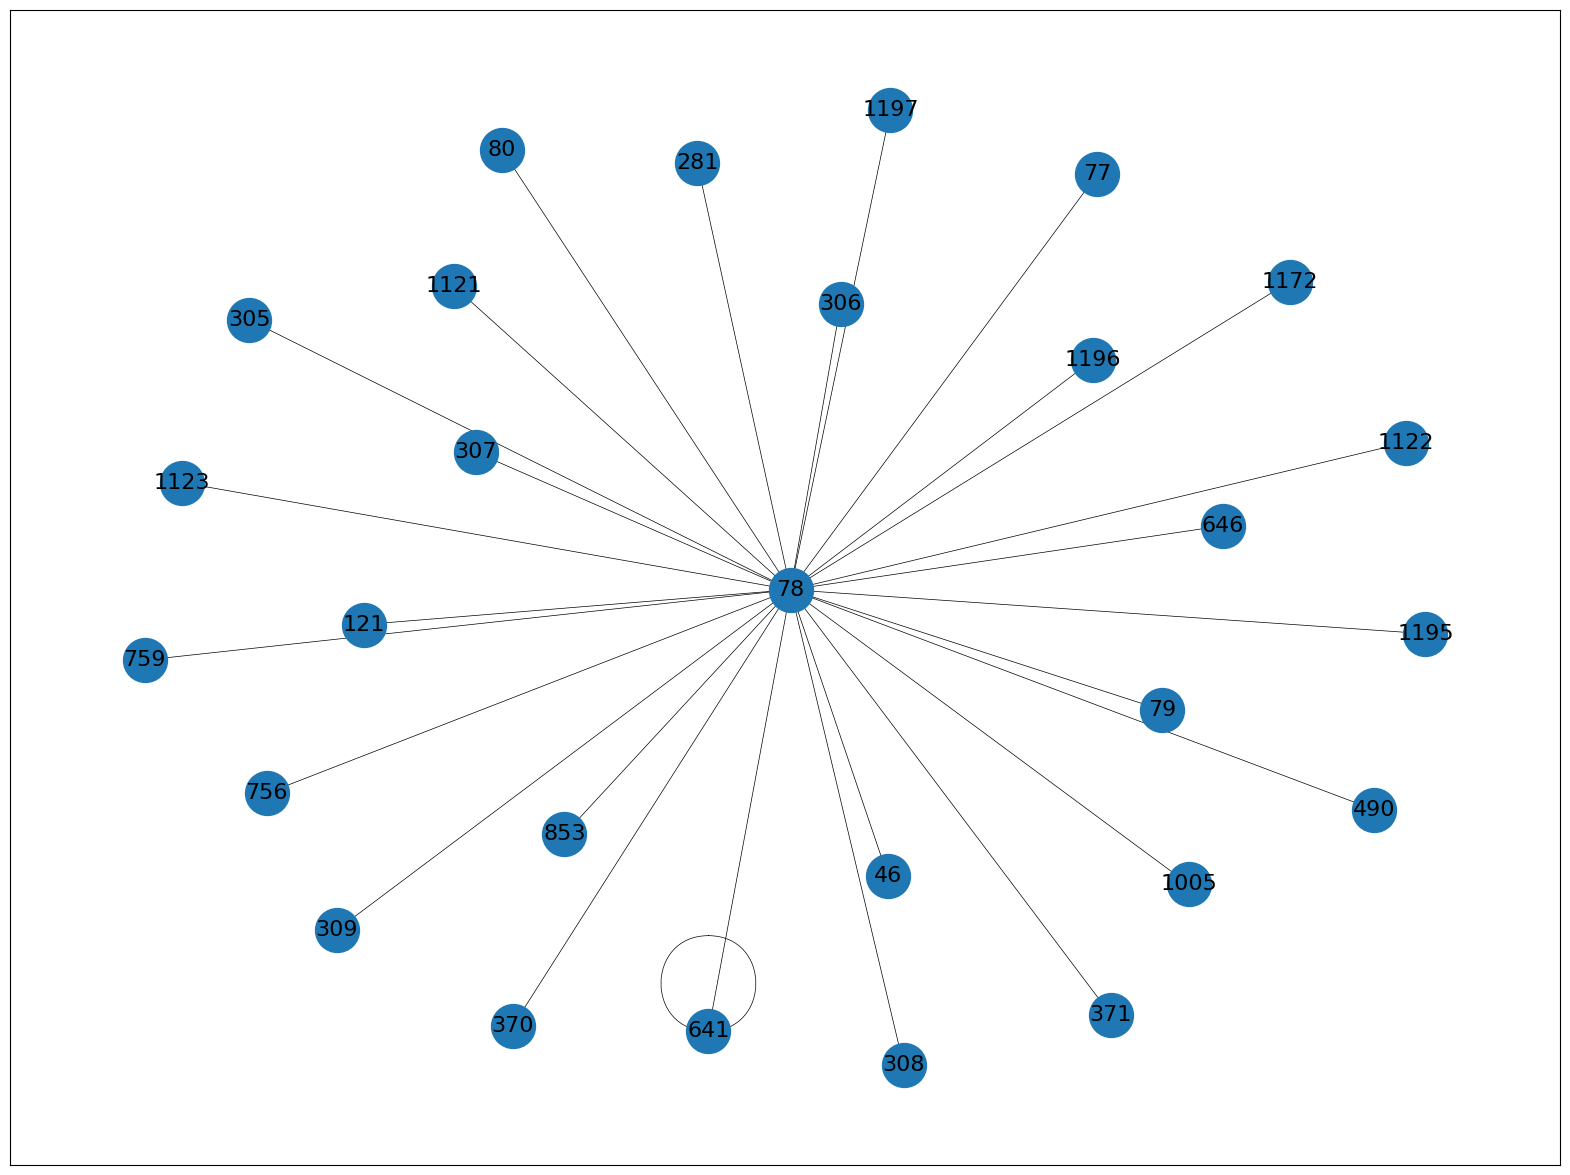

In [128]:

queue = [(641, 641)]
# for node in sampled_nodes:
#     queue.append((node, 9))

bfs(queue, ns_graph, sub_graph, 2)

plt.figure(figsize=(20,15))
nx.draw_networkx(sub_graph,
                 node_size=1000,
                 font_size=16,
                 width=0.5,
                 arrowsize=10,
                 with_labels=True)

In [123]:
feature_vectors[641]

[1,
 1,
 26,
 27.0,
 49.0,
 61.0,
 27,
 49,
 61,
 27.0,
 49.0,
 61.0,
 4.888888888888889,
 9.814814814814815,
 31.333333333333332,
 132.0,
 265.0,
 846.0,
 27,
 49,
 61,
 4.888888888888889,
 9.814814814814815,
 31.333333333333332,
 132,
 265,
 846]

Feature vectors

for 641

index-0 : 1 => Only one node is connected with the node 641

index-1 : 1 => Only one edge exist in the egonet (node and its immediate neighbours)

index-2 : 26 => 26 edges are exiting the egonet of node 641, i.e node 641 is a leaf node connected with a highly dense node